In [1]:
import numpy as np
import numpy.linalg as lng  # linear algebra
import matplotlib.pyplot as plt
import scipy.stats as stats  # pour la fonction de repartition de la loi normale
import pandas as pd  # pour un meilleur affichage des tables
import time

import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")


# Introduction au TP  

Dans ce TP, nous allons nous intéresser à la programmation du prix du Put Européen par différents schémas de discrétisation :

- Schéma **Euler Explicite**
- Schéma **Euler Implicite**
- Schéma **Crank-Nicolson**

Nous allons étudier la mise en oeuvre de ces différents schémas numériques via leur stabilité pour différentes valeurs de $I$ et $N$ correspondant respectivement aux nombres de points dans le mersh spartial et temporel.



Dans le **Complément n°1**, nous allons nous intéresser à l'implémentation de la formule de Black-Scholes pour le Put Européen et ainsi observer l'erreur commise par le calcul par EDP par rapport à la formule fermée.


Dans le **Complément n°2**, nous allons nous intéresser aux matrices sparses afin d'étudier le gain computationnel lié à leur utilisation par rapport aux tableaux numpy classiques.

Dans le **Complément n°3**, nous allons nous intéresser au cas du Call Européen et nous introduirons l'EDP à laquelle il est solution ainsi que ses conditions limites. Nous verrons également quelques graphiques qui illustrent les différents schémas de discrétisation pour cette option.


# Programmation de EE, EI et CN




In [2]:
""" Paramètres constants: """
r=0.1
sigma=0.2
S_max=200
S_min=0
K=100
T=1

""" Fonctions paramètres qui vont servir pour l'implémentation des différents
    schémas: """

def u0(s):
  return max(K-s,0)

def uleft(t):
  return K*np.exp(-r*t) - S_min

def uright(t):
  return 0


def parametres(I):
  h = (S_max - S_min)/I
  s = [j*h + S_min for j in range(I+1)]
  alpha = [(((sigma*s[i])/h)**2)/2 for i in range(I+1)]
  beta = [r*s[i]/(2*h) for i in range(I+1)]
  return h, s, alpha, beta


def create_A(I):
  h,s,alpha,beta = parametres(I)
  main_diag = 2*np.array(alpha[1:I+1]) + r
  lower_diag = -np.array(alpha[2:I+1]) + np.array(beta[2:I+1])
  upper_diag = -np.array(alpha[1:I]) - np.array(beta[1:I])
  A = np.diag(main_diag) + np.diag(lower_diag, -1) + np.diag(upper_diag, 1)
  return A

def create_U0(I):
  h,s,alpha,beta = parametres(I)
  U0 = np.zeros((I,1))
  for i in range(I):
    U0[i] = u0(s[i])
  return U0


def q(t,I):
  h,s,alpha,beta = parametres(I)
  q = np.zeros((I,1))
  q[0,0] = (-alpha[1] + beta[1])*uleft(t)
  return q

""" Implémentation des schémas EE, IE et CN dans le cas du put: """

# Schéma Euler Explicite en fonction de I et N
def ExplicitEuler(I,N):
  U = create_U0(I)
  A = create_A(I)
  dt = T/N
  for n in range(0,N):
    t = n*dt
    U = U - dt*(A @ U + q(t,I))
  return U

# Schéma Euler Implicite en fonction de I et N
def ImplicitEuler(I,N):
  U = create_U0(I)
  A = create_A(I)
  dt = T/N
  B = np.identity(I) + dt*A
  for n in range(0,N):
    t = n*dt
    U = lng.solve(B, -dt*q(t,I) + U)
  return U

# Schéma CrankNicolson en fonction de I et N
def Crank_Nicolson(I,N):
  U = create_U0(I)
  A = create_A(I)
  theta = 0.5
  dt = T/N
  B = np.identity(I) + theta*dt*A
  for n in range(0,N):
    t = n*dt
    F = -(theta *q(t,I) + (1 - theta) * q(t,I))
    part1 = U - (1 - theta) * dt * (A @ U)
    U = lng.solve(B,dt * F + part1)
  return U

# Affiche les coubres des schémas et du payoff, selon le schéma choisi 'SCHEME',
# de I et de N:

def plot_Euler(func,I,N):
  plt.figure(figsize=(5,3))
  h,s,alpha,beta = parametres(I)
  U0_values = [u0(s[i]) for i in range(I+1)]
  plt.plot(s[:I+1], U0_values, label='Payoff', linestyle='--',
           color = 'black')

  Scheme_values = func(I,N)
  plt.plot(s[:I], Scheme_values[:I],
             label=func.__name__, color = "b")

  plt.xlabel('Prix du sous-jacent (S)')
  plt.ylabel('Prix du Put')
  plt.title("Pricing du Put Européen par le schema {} avec T ={}, I= {},  N= {}".format(func.__name__,T,I,N))
  plt.legend()
  plt.yticks(range(0, int(max(U0_values)) + 10, 10))
  plt.grid(True)
  plt.show()
  print()

# Par exemple, on test avec le schéma "EE", pour I = N = 20
# plot_Euler(Crank_Nicolson,20,20)


##  **Figures et Résultats Numériques**


Nous nous sommes intéressés dans un premier temps à l'implémentation des différents schémas pour différentes valeurs de $I$ et $N$.

Dans un premier temps, nous donnons ci-dessus l'allure des figures obtenues pour seulement $I$ qui varie et pour $N=10$


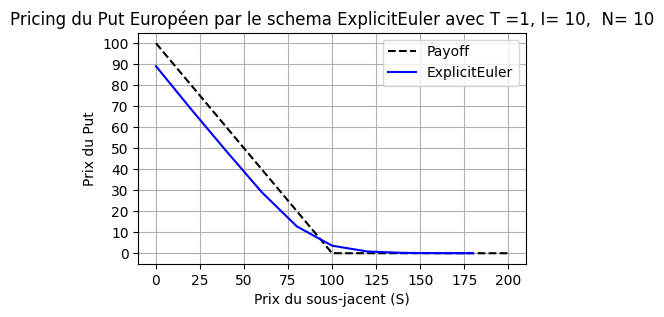

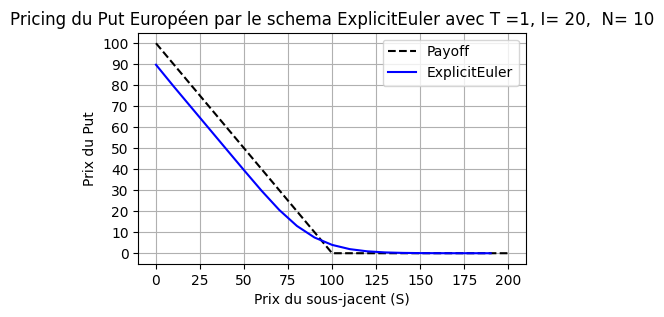

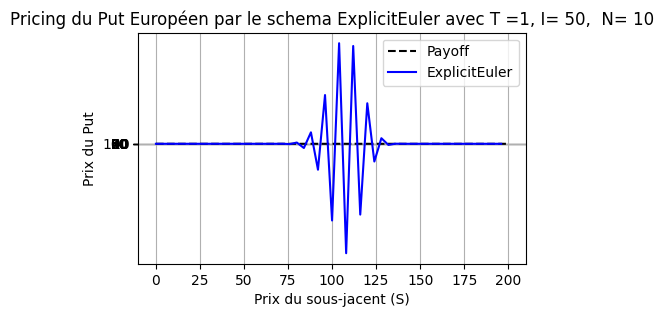

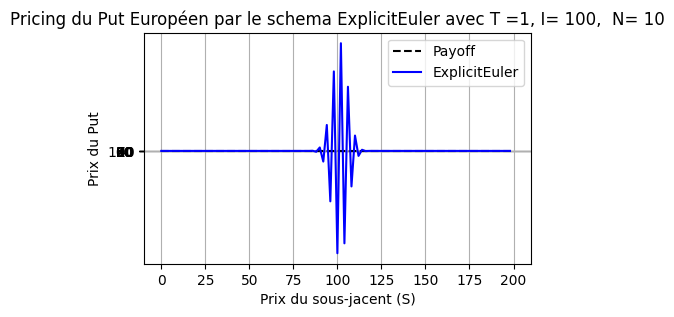

In [3]:
""" Test affichage des courbes avec seulement I qui varie puis avec I et N
    qui varient  """

# Pour afficher les graphiques : On doit modifier la fonctionnelle le paramètre func avec le nom de la fonction utilisé :
# Soit - ExplicitEuler,ImplicitEuler,Crank_Nicolson

def plot_test(func,stable):
    if stable=="same":
        for I in [10,20,50,100]:
            plot_Euler(func,I,10)
    else:
        for I in [10,20,50,100]:
            plot_Euler(func,I,I)

plot_test(ExplicitEuler,"same")

Nous remarquons à la suite de ces graphes la présence de problèmes d'oscillations pour des valeurs croissantes de I et $N=10$ traduisant l'instabilité du schéma numérique d'Euler Explicite.

Nous allons ici nous intéresser ici aux figures obtenues pour des valeurs telles que $I=N$

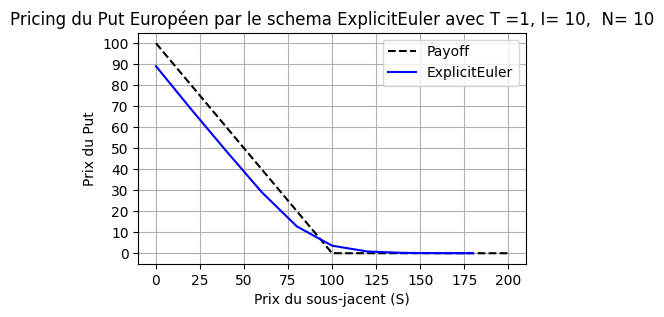

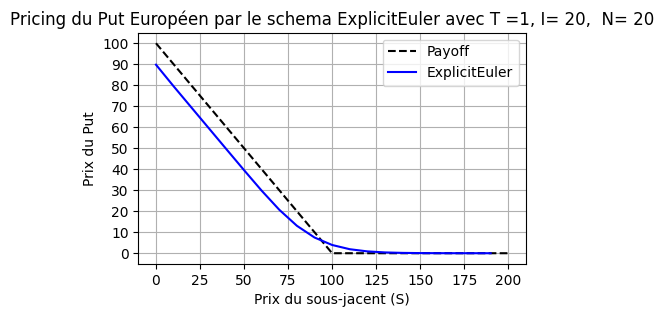

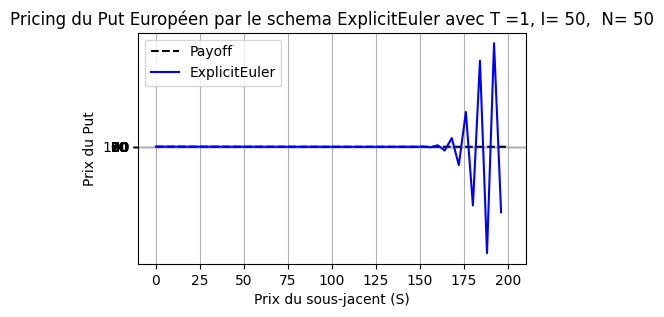

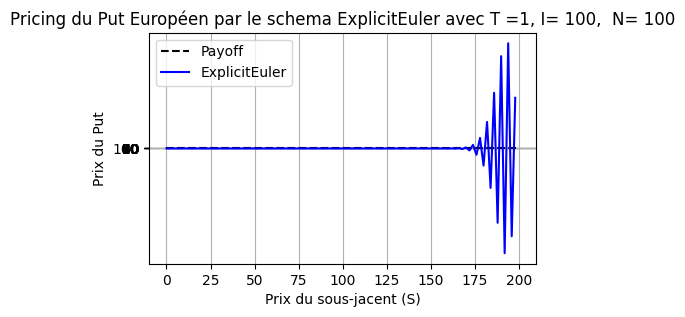

In [4]:
plot_test(ExplicitEuler,"notsame")

Nous remarquons également à la suite de ces graphes la présence de problèmes d'oscillations pour de grandes valeurs de $I$ et $N$ telles que $I=N$ traduisant l'instabilité du schéma numérique d'Euler Explicite.

Pour étudier ce problème, nous avons étudié la matrice d'amplification définie comme suit :

 $B=I_{d}-\Delta t A$
    
    

- $I_{d}$ correspond à la matrice identité de $R^{d}$
- A correspond à la matrice tridiagonale introduise dans le TP.


On donne ci-dessous les résultats obtenues pour différentes valeurs de $I$ et $N$ pour la matrice d'amplification.

In [5]:
""" Définition de la matrice d'amplification: """

def amplification(I,N):
  dt = T/N
  A = create_A(I)
  B = np.identity(I) - dt*A
  data={"norme inf": lng.norm(B,np.inf),
          "norme 2": lng.norm(B,2),
        "coeffs B >=0":np.all(B>=0),
        "coeffs de B <0 " :np.sum(B<0),
        "coeffs B <=1":np.all(B<=1)}
  Result=pd.DataFrame(data,index=["I={}, N={}".format(I,N)])
  return Result


amplification(50,10)


,norme inf,norme 2,coeffs B >=0,coeffs de B <0,coeffs B <=1
"I=50, N=10",18.218,16.473976,False,36,False


On voit dans le cas où $(I,N)=(50,10)$ que la matrice d'amplification est bien un indicateur de la non stabilité du schéma d'Euler Explicite avec un nombre de coefficients de $B$ négatifs bien trop élévés impliquant que la matrice $A$ explose en norme.

In [6]:
amplification(10,10)

,norme inf,norme 2,coeffs B >=0,coeffs de B <0,coeffs B <=1
"I=10, N=10",0.994,0.986915,False,1,True


On voit dans le cas où $(I,N)=(10,10)$ que la matrice d'amplification est également bien un indicateur de la stabilité du schéma d'Euler Explicite avec un nombre de coefficients de $B$ avec la norme de $B$ étant bien inférieure à 1 ce qui assure la non divergence de la matrice $A$

On a également introduit le **CFL** number qui est également un indicateur de la stabilité du schéma d'Euler Explicite dont on donne l'expression ci-dessous :


<center>
$\mu =\frac{\Delta t \sigma^{2}Smax^{2}}{h^{2}}$
</center>
    
On donne ci-dessous les valeurs obtenues du **CFL** pour les 2 cas considérés : $(I,N)=(10,10)$ et $(I,N)=(50,10)$


In [8]:
""" Définition du CFL number: """

def CFL_number(I,N):
  h = h = (S_max - S_min)/I
  dt = T/N
  return dt * (sigma*S_max/h)**2

# On va verifier que quand le CFL est petit, il n'y a pas de problème
# de stabilité;

def check_CFL(func):
  I,N,norminf,norme2,CFL=[],[],[],[],[]
  for i in [10,50]:
    I.append(i)
    N.append(10)

    norm = amplification(i,10)
    norminf.append(norm["norme 2"][0])
    norme2.append(norm["norme inf"][0])
    cfl = CFL_number(i,10)
    CFL.append(cfl)
    # plot_Euler(func, i,10)
  data = {"I": I,"N":N, 'Norme Inf': norminf,"Norme 2": norme2,"CFL":CFL}
  Result = pd.DataFrame(data)
  return Result

check_CFL(ExplicitEuler)


,I,N,Norme Inf,Norme 2,CFL
0,10,10,0.986915,0.994,0.4
1,50,10,16.473976,18.218,10.0


On observe bien l'effet observé : Plus le CFL est faible et plus le schéma de discrétisation est cohérent.

In [9]:
""" Définition du P1-Interpolate: """

def BS_Put(S):
  d1 = (np.log(S/K)+(r + 0.5*(sigma**2))*T) / (sigma*np.sqrt(T))
  d2 = (np.log(S/K)+(r - 0.5*(sigma**2))*T) / (sigma*np.sqrt(T))
  return K*np.exp(-r*T)*stats.norm.cdf(-d2) - S*stats.norm.cdf(-d1)


def P_Interpolate(s_bar,func,I,N):
  h,s,alpha,beta = parametres(I)
  s_ = np.array(s)
  i = np.argmax(s_ >= s_bar)
  U = func(I,N)
  u_bar=((s[i]-s_bar)*U[i-1]+(s_bar-s[i-1])*U[i])/h
  return float(u_bar)

def errex(s_bar,func,I,N):
  return abs(P_Interpolate(s_bar,func,I,N)-BS_Put(s_bar))

#P_Interpolate(90,ExplicitEuler, 10, 20)
# errex(80,ExplicitEuler,20,40)

Nous allons maintenant nous intéresser aux différents ordres numériques en calculant les différentes quantités suivants :

<center>
 $e_{k}=\lvert U^{(k-1)}(\bar{s})-U^{(k)}(\bar{s}) \rvert$ qui correspond à l'erreur.
<center>
 $errex_{k}=\lvert U^{(k)}(\bar{s})-v(T,\bar{s}) \rvert$ qui correspond à l'erreur par rapport au prix Black-Scholes du Put.
<center>
$\alpha_{k}=\frac{log(\frac{e_{k-1}}{e_{k}})}{log(\frac{h_{k-1}}{h_{k}})}$ où dans notre cas $h_{k}=\frac{h_{k-1}}{2}$ et $\alpha_{k}$ doit donner une approximation de l'ordre.


In [10]:
""" question e) Numerical order of the scheme dans test numeriques à faire !!!"""


import pandas as pd

def tableau(func):
    I = [10, 20, 40, 80, 160]
    N = [10,40,160,640,2560]
    sbar = 80
    Us, error, alpha1, errex1, tcpu = [], [], [], [], []
    t0=time.time()
    for i in range(len(I)):
            Us.append(P_Interpolate(sbar, func, I[i], N[i]))
            t1=time.time()
            tcpu_str = "tcpu=%5.6f"%(t1-t0)
            equal_sign_index = tcpu_str.index('=')
            numeric_part = tcpu_str[equal_sign_index + 1:]
            tcpu_float = float(numeric_part)
            tcpu.append(tcpu_float)

            if i == 0:
                error.append(0)
                errex1.append(0)
                alpha1.append(0)

            elif i==1:
              alpha1.append(0.294991)
              error.append(abs(P_Interpolate(sbar, func, I[i-1], N[i-1]) - P_Interpolate(sbar, func, I[i], N[i])))
              errex1.append(errex(sbar, func, I[i], N[i]))

            else:
                errex1.append(errex(sbar, func, I[i], N[i]))
                error.append(abs(P_Interpolate(sbar, func, I[i-1], N[i-1]) - P_Interpolate(sbar, func, I[i], N[i])))
                alpha1.append((np.log(error[i-1]/error[i])/np.log(2)))


    data = {"I": I, 'N': N, 'U(s)': Us, "errex": errex1, "error": error,"alpha":alpha1,"tcpu":tcpu}
    Result = pd.DataFrame(data)
    return Result



On donne ci-dessous les tableaux obtenus pour le schéma **Euler Explicite** :

In [11]:
tableau(ExplicitEuler) # Tableau de données pour le schéma EE

,I,N,U(s),errex,error,alpha,tcpu
0,10,10,12.745518,0.000000,0.000000,0.000000,0.000568
1,20,40,13.100186,0.173477,0.354668,0.294991,0.001929
2,40,160,13.214570,0.059093,0.114385,1.632576,0.009939
3,80,640,13.250817,0.022846,0.036247,1.657971,0.039565
4,160,2560,13.263831,0.009832,0.013014,1.477821,0.380578


On remarque clairement que le schéma numérique n'est pas stable dans le cas où $I=N$ comme attendu car on doit avoir un $\Delta t \approx h^{2}$.
Cependant, dans le tableau ci-dessous, lorsque $I=N^{2}/10$ et donc $\Delta t \approx h^{2}$ , on retrouve bien une stabilité dans le schéma ce qui est bien cohérent avec la théorie observée.

In [12]:
tableau(ExplicitEuler) # Tableau de données pour le schéma EE

,I,N,U(s),errex,error,alpha,tcpu
0,10,10,12.745518,0.000000,0.000000,0.000000,0.000290
1,20,40,13.100186,0.173477,0.354668,0.294991,0.000949
2,40,160,13.214570,0.059093,0.114385,1.632576,0.010884
3,80,640,13.250817,0.022846,0.036247,1.657971,0.037235
4,160,2560,13.263831,0.009832,0.013014,1.477821,0.325798


On donne ci-dessous les tableaux obtenus  pour le Schéma **Euler Implicite** avec en premier le tableau tel que $I=N$ puis $I=N/10$.

In [13]:
tableau(ImplicitEuler) # Tableau de données pour le schéma IE

,I,N,U(s),errex,error,alpha,tcpu
0,10,10,13.055937,0.000000,0.000000,0.000000,0.000643
1,20,40,13.169004,0.104659,0.113067,0.294991,0.004659
2,40,160,13.230999,0.042664,0.061995,0.866959,0.022285
3,80,640,13.254914,0.018749,0.023915,1.374204,0.123812
4,160,2560,13.264859,0.008804,0.009944,1.266015,1.333727


In [14]:
tableau(ImplicitEuler) # Tableau de données pour le schéma IE

,I,N,U(s),errex,error,alpha,tcpu
0,10,10,13.055937,0.000000,0.000000,0.000000,0.000459
1,20,40,13.169004,0.104659,0.113067,0.294991,0.001978
2,40,160,13.230999,0.042664,0.061995,0.866959,0.023524
3,80,640,13.254914,0.018749,0.023915,1.374204,0.125095
4,160,2560,13.264859,0.008804,0.009944,1.266015,1.344572


On remarque clairement que le schéma numérique est stable dans le cas où $I=N$ ainsi que dans le cas $I=N/10$ ce qui est bien cohérent avec la théorie
Cependant, dans le tableau ci-dessous, lorsque $I=N^{2}/10$ et donc $\Delta t \approx h^{2}$ , on retrouve bien une stabilité dans le schéma ce qui est bien cohérent avec la théorie observée.

On donne ci-dessous les tableaux obtenus  pour le Schéma **Crank Nicolson** avec en premier le tableau tel que $I=N$ puis $I=N/10$.

In [15]:
tableau(Crank_Nicolson) # Tableau de données pour le schéma IE

,I,N,U(s),errex,error,alpha,tcpu
0,10,10,12.901743,0.000000,0.000000,0.000000,0.000694
1,20,40,13.134417,0.139246,0.232674,0.294991,0.003428
2,40,160,13.222773,0.050890,0.088356,1.396909,0.032551
3,80,640,13.252865,0.020798,0.030092,1.553955,0.187270
4,160,2560,13.264345,0.009318,0.011480,1.390312,1.789542


In [ ]:
tableau(Crank_Nicolson) # Tableau de données pour le schéma CN

,I,N,U(s),errex,error,alpha,tcpu
0,10,1,12.370891,0.000000,0.000000,0.000000,0.000000
1,20,2,12.984943,0.288720,0.614052,0.294991,0.000000
2,40,4,13.205334,0.068329,0.220391,1.478294,0.015554
3,80,8,13.247582,0.026081,0.042248,2.383109,0.015554
4,160,16,13.263029,0.010634,0.015447,1.451556,0.025159


# **Complément 1: Implémentation formule de BS pour le Put Européen**

Dans ce complément n°1, on va s'intéresser à l'erreur relative entre le prix BS du Put Européen obtenu par formule fermée et l'approximation que nous avons faite via l'EDP.

On donne ci-dessous $v(t,S)$ la valeur du prix du Put Européen pour le sous-jacent de valeur $S$ en $t$ :

<center>
$v(t,S)=Ke^{-rt}N(-d_{-})-SN(-d_{+})$
<center>
 Avec
<center>
$d_{+}=\frac{log({\frac{S}{K})+(r+\frac{\sigma^{2}}{2})t}}{\sigma t}$
<center>
$d_{-}=\frac{log({\frac{S}{K})+(r-\frac{\sigma^{2}}{2})t}}{\sigma t}$
<center>
$N$ la fonction de répartition de la loi normale centrée réduite

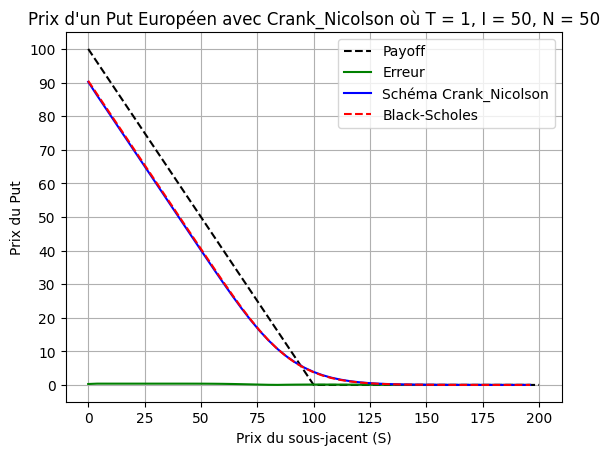

In [16]:
#Formule de BS pour le prix du Put Européen
def BS_Put(S):
  d1 = (np.log(S/K)+(r + 0.5*(sigma**2))*T) / (sigma*np.sqrt(T))
  d2 = (np.log(S/K)+(r - 0.5*(sigma**2))*T) / (sigma*np.sqrt(T))
  return K*np.exp(-r*T)*stats.norm.cdf(-d2) - S*stats.norm.cdf(-d1)


def plot_Euler_Bs(func, I, N):
    plt.figsize=((5,5))
    h, s, alpha, beta = parametres(I)
    U0_values = [u0(s[i]) for i in range(I+1)]

    # Solutions numériques par les différents schémas
    numerical_values = func(I, N)

    # Valeurs de Black-Scholes, i.e les 'vraies' valeurs
    bs_values = [BS_Put(s[i]) for i in range(I)]
    # On calcul l'erreur en prenant la différence en valeur absolue
    error_values = np.zeros(I)
    for i in range(I):
      error_values[i] = np.abs(bs_values[i] - numerical_values[i])

    plt.plot(s[:I+1], U0_values, label='Payoff', linestyle='--', color='black')
    plt.plot(s[:I], error_values, label='Erreur', color='g')
    plt.plot(s[:I], numerical_values[:I], label=f'Schéma {func.__name__}', color='b')
    plt.plot(s[:I], bs_values[:I], label='Black-Scholes',
             linestyle='dashed', color='r')



    plt.xlabel('Prix du sous-jacent (S)')
    plt.ylabel('Prix du Put')
    plt.title(f"Prix d'un Put Européen avec {func.__name__} où T = {T}, I = {I}, N = {N}")
    plt.legend()
    plt.yticks(range(0, int(max(U0_values)) + 10, 10))
    plt.grid(True)
    plt.show()
    print()

plot_Euler_Bs(Crank_Nicolson, 50, 50)

On voit sur cet exemple que l'erreur est très faible entre le prix $Black-Scholes$ en rouge et le prix obtenu via résolution de l'EDP en bleu ce qui nous rassure sur la bonne résolution de l'EDP du Put Européen.

# **Complément 2: Sparses matrices**

Dans cette section, on va s'intéresser à l'utilisation des matrices sparses via un package Python qui permet de réduire significativement le temps de calcul avec des tableaux numpy qui contiennent beaucoup de 0.
En effet, dans notre problème, la matrice $A$ est tri-diagonale donc rentre dans ce cadre là et l'utilisation des matrices sparses permet de gérer celà et de réduire significativement le temps de calcul.

In [17]:
from scipy.sparse import csr_matrix
from scipy import sparse as sparse
from scipy.sparse.linalg import cg
from scipy.sparse.linalg import spsolve


In [18]:
""" On modifie uniquement les fonctions où A intervient, et on la transforme
    en format Sparse """


def create_A_Sparse(I):
  h,s,alpha,beta = parametres(I)
  main_diag = 2*np.array(alpha[1:I+1]) + r
  lower_diag = -np.array(alpha[2:I+1]) + np.array(beta[2:I+1])
  upper_diag = -np.array(alpha[1:I]) - np.array(beta[1:I])
  A = np.diag(main_diag) + np.diag(lower_diag, -1) + np.diag(upper_diag, 1)
  A_sparse = csr_matrix(A)  # On convertie A en format Sparse CSR
  return A_sparse


# Schéma Euler Explicite en fonction de I et N
def ExplicitEuler_Sparse(I,N):
  U = create_U0(I)
  A = create_A_Sparse(I)
  dt = T/N
  for n in range(0,N):
    t = n*dt
    U = U - dt*(A @ U + q(t,I))
  return U

# Schéma Euler Implicite en fonction de I et N
def ImplicitEuler_Sparse(I,N):
  U = create_U0(I)
  A = create_A_Sparse(I)
  dt = T/N
  Id = sparse.identity(I)
  B = Id + dt*A
  for n in range(0,N):
    t = n*dt
    U, _ = cg(B, -dt*q(t,I) + U)
    U = U.reshape(-1,1)
  return U

# Schéma CrankNicolson en fonction de I et N
def Crank_Nicolson_Sparse(I,N):
  U = create_U0(I)
  A = create_A_Sparse(I)
  theta = 0.5
  dt = T/N
  Id = sparse.identity(I)
  B = Id + theta*dt*A
  for n in range(0,N):
    t = n*dt
    F = -(theta *q(t,I) + (1 - theta) * q(t,I))
    part1 = U - (1 - theta) * dt * (A @ U)
    U, _ = cg(B, dt * F + part1)
    U = U.reshape(-1,1)
  return U



# Plot les coubres des schémas et du payoff, en fonction du schéma choisit 'SCHEME',
# de I et de N
def plot_Euler_Sparse(func,I,N):
  h,s,alpha,beta = parametres(I)
  U0_values = [u0(s[i]) for i in range(I+1)]
  plt.plot(s[:I+1], U0_values, label='Payoff', linestyle='--',
           color = 'black')

  numerical_values = func(I,N)
  plt.plot(s[:I], numerical_values[:I],
             label=func.__name__, color = "b")

  plt.xlabel('Prix du sous-jacent (S)')
  plt.ylabel('Prix du Put')
  plt.title("Pricing du Put Européen par le schema {} avec T={}, I={},  N={}".format(func.__name__,T,I,N))
  plt.legend()
  plt.yticks(range(0, int(max(U0_values)) + 10, 10))
  plt.grid(True)
  plt.show()
  print()

#plot_Euler_Sparse(ExplicitEuler_Sparse, 120, 20)
#plot_Euler_Sparse(ImplicitEuler_Sparse, 120, 20)
#plot_Euler_Sparse(Crank_Nicolson_Sparse, 120, 20)

In [19]:
""" Comparatif des performances sans et avec Sparse """

import time


def measure_execution_time(func, I,N):
    start_time = time.time()
    func(I,N)
    end_time = time.time()
    return end_time - start_time


def plot_time(func1, func2):
  I = [10,100,200,300,400,500,750,1000]
  time_numpy = [0]*len(I)
  time_sparse = [0]*len(I)
  index = 0
  for i in I:
      time_numpy[index] = measure_execution_time(func1, i, i)
      time_sparse[index] = measure_execution_time(func2, i, i)
      index += 1
  plt.figure(figsize=(5,3.5))
  plt.plot(I, time_numpy, label=func1.__name__, color='b')
  plt.plot(I, time_sparse, label=func2.__name__, color='r')
  plt.xlabel('Valeurs de I (=N)')
  plt.ylabel('Temps d\'exécution en secondes')
  plt.title(f'Performance de {func1.__name__} vs {func2.__name__}')
  plt.legend()
  plt.show()
  print()


On donne ci-dessous l'évolution des performances en terme de temps d'éxécution pour les différents schémas de discrétisation pour différentes valeurs de $(I=N)$ en fonction de l'utilisation des matrices sparses ou non.

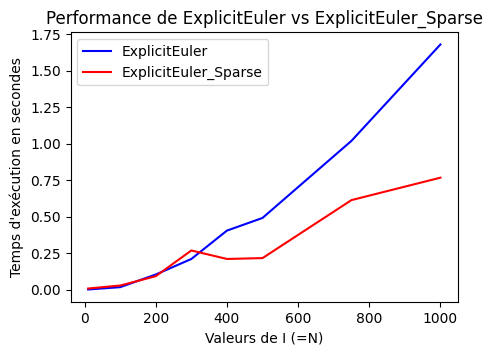

In [20]:
plot_time(ExplicitEuler,ExplicitEuler_Sparse)

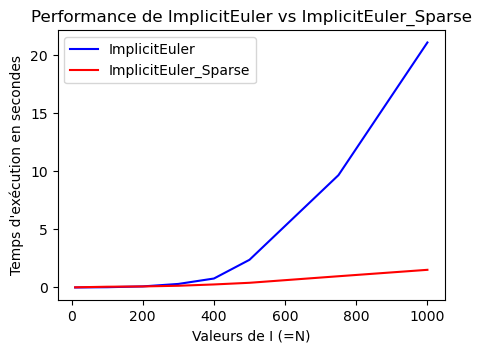

In [ ]:
plot_time(ImplicitEuler,ImplicitEuler_Sparse)

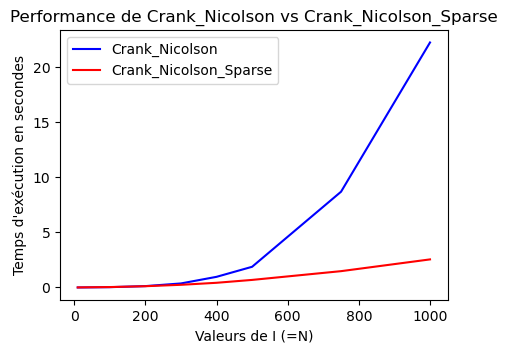

In [ ]:
plot_time(Crank_Nicolson,Crank_Nicolson_Sparse)

# **Complément 3: Cas du Call européen**


On introduit les conditions au bord qui sont modifiées pour le cas du call européen :

- $v(t,S_{min})= 0   \forall t \in (0,T)$
-  $v(t,S_{max})=Smax-Ke^{-rt}  \forall t \in (0,T)$
- $v(0,s)=max(s-K,0)$

Par ailleurs, l'EDP satisfaite par l'option du Call Européen est exactement la même et est donnée par :

<center>
$\frac{\partial v}{\partial t}+\frac{\sigma^{2}s^{2}}{2}\frac{\partial^{2} v}{\partial s^{2}}+rs\frac{\partial v}{\partial s}-rv=0 , \forall t \in (0,T) , \forall s \in (Smin,Smax)$


Dès lors, on est possible de donner par les différentes méthodes proposées dans ce TP le prix du Call Européen dans le modèle de Black-Scholes.
    

On donne ci-dessous les résultats associés à la simulation avec les 3 méthodes :



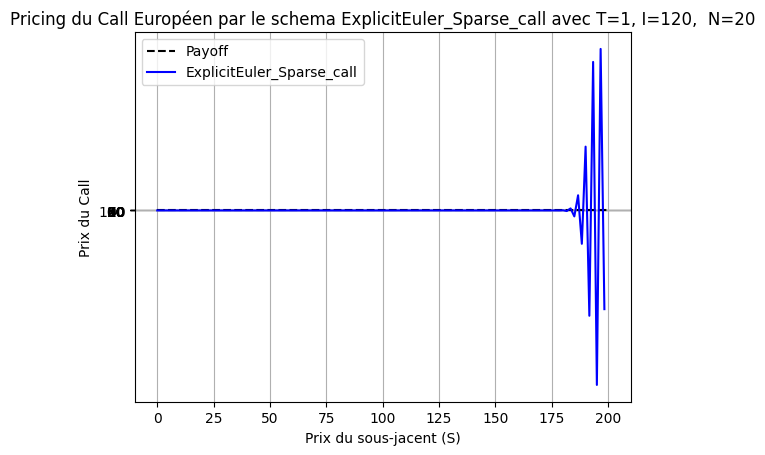

In [21]:
""" On garde le même code en modifiant simplement les fonctions de bases,
    et en utilisant ici les matrices Sparses car c'est plus rapide """

def u0_call(s):
  return max(s-K,0)

def uleft_call(t):
  return 0

def uright_call(t):
  return -K*np.exp(-r*t) + S_max


def create_U0_call(I):
  h,s,alpha,beta = parametres(I)
  U0 = np.zeros((I,1))
  for i in range(I):
    U0[i] = u0_call(s[i])
  return U0


def q_call(t,I):
  h,s,alpha,beta = parametres(I)
  q = np.zeros((I,1))
  q[0,0] = (-alpha[1] + beta[1])*uleft_call(t)
  q[I-1,0] = (-alpha[I] - beta[I])*uright_call(t)
  return q



# Schéma Euler Explicite en fonction de I et N
def ExplicitEuler_Sparse_call(I,N):
  U = create_U0_call(I)
  A = create_A_Sparse(I)
  dt = T/N
  for n in range(0,N):
    t = n*dt
    U = U - dt*(A @ U + q_call(t,I))
  return U

# Schéma Euler Implicite en fonction de I et N
def ImplicitEuler_Sparse_call(I,N):
  U = create_U0_call(I)
  A = create_A_Sparse(I)
  dt = T/N
  Id = sparse.identity(I)
  B = Id + dt*A
  for n in range(0,N):
    t = n*dt
    U, _ = cg(B, -dt*q_call(t,I) + U)  # Utilisation de cg au lieu de spsolve
    U = U.reshape(-1,1)
  return U

# Schéma CrankNicolson en fonction de I et N
def Crank_Nicolson_Sparse_call(I,N):
  U = create_U0_call(I)
  A = create_A_Sparse(I)
  theta = 0.5
  dt = T/N
  Id = sparse.identity(I)
  B = Id + theta*dt*A
  for n in range(0,N):
    t = n*dt
    F = -(theta *q_call(t,I) + (1 - theta) * q_call(t,I))
    part1 = U - (1 - theta) * dt * (A @ U)
    U, _ = cg(B, dt * F + part1)  # Utilisation de cg au lieu de spsolve
    U = U.reshape(-1,1)
  return U




# Plot les coubres des schémas et du payoff, en fonction du schéma choisit 'SCHEME',
# de I et de N
def plot_Euler_Sparse_call(func,I,N):
  h,s,alpha,beta = parametres(I)
  U0_values = [u0_call(s[i]) for i in range(I+1)]
  plt.plot(s[:I+1], U0_values, label='Payoff', linestyle='--',
           color = 'black')

  numerical_values = func(I,N)
  plt.plot(s[:I], numerical_values[:I],
             label=func.__name__, color = "b")

  plt.xlabel('Prix du sous-jacent (S)')
  plt.ylabel('Prix du Call')
  plt.title("Pricing du Call Européen par le schema {} avec T={}, I={},  N={}".format(func.__name__,T,I,N))
  plt.legend()
  plt.yticks(range(0, int(max(U0_values)) + 10, 10))
  plt.grid(True)
  plt.show()
  print()

plot_Euler_Sparse_call(ExplicitEuler_Sparse_call, 120, 20)


On voit que dans le cas du schéma d'Euler Explicite pour le Call Européen associé aux paramètres $(I,N)=(120,20)$, on retrouve ce problème de consistance du schéma que nous avions précédemment remarqué dans le cadre du put européen ce qui est normal car seuls les conditions au bord ont été modifiés entre la construction de ces 2 schémas.

On donne-ci dessous pour ces mêmes paramètres $I$ et $N$ les graphes obtenus pour les méthodes **EulerImplicite** et **CrankNicolson** :

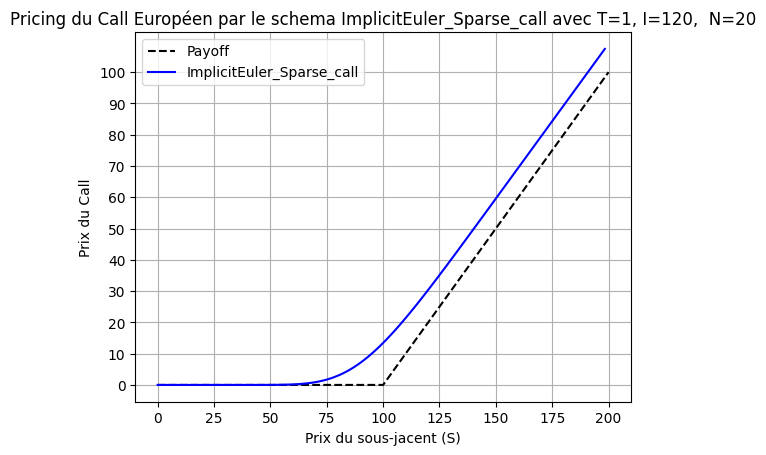

In [22]:
plot_Euler_Sparse_call(ImplicitEuler_Sparse_call, 120, 20)


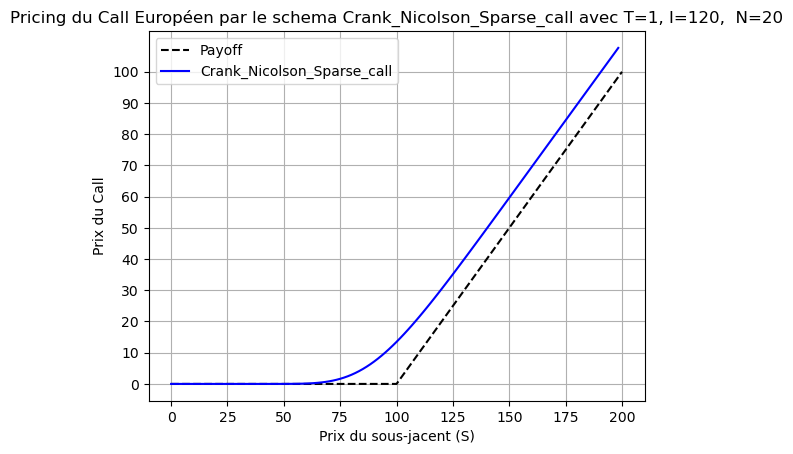

In [ ]:
plot_Euler_Sparse_call(Crank_Nicolson_Sparse_call, 120, 20)

On s'est également intéressés au sein d'un même graphique à l'erreur obtenue par la méthode d'Euler Implicite par rapport à la formule fermée de Black-Scholes que l'on a représenté ci-dessous.

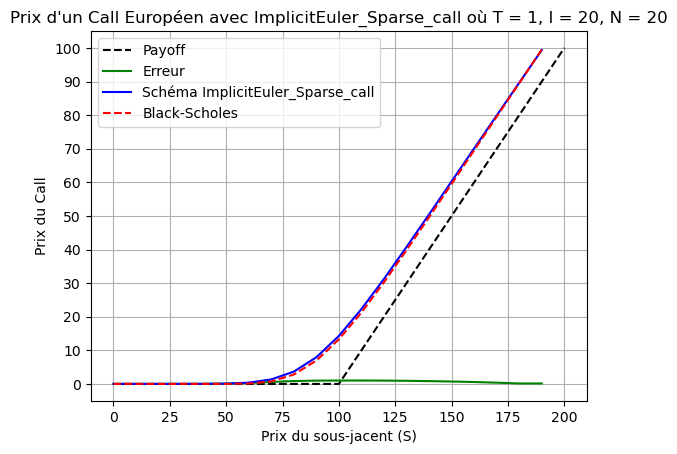

In [ ]:
"On compare l'erreur dans le cas du Call, toujours avec le même code"


def BS_Call(S):
  d1 = (np.log(S/K)+(r + 0.5*(sigma**2))*T) / (sigma*np.sqrt(T))
  d2 = (np.log(S/K)+(r - 0.5*(sigma**2))*T) / (sigma*np.sqrt(T))
  return -K*np.exp(-r*T)*stats.norm.cdf(d2) + S*stats.norm.cdf(d1)


def plot_Euler_Bs_call(func, I, N):
    h, s, alpha, beta = parametres(I)
    U0_values = [u0_call(s[i]) for i in range(I+1)]

    # Solutions numériques
    numerical_values = func(I, N)

    # Valeurs de Black-Scholes
    bs_values = [BS_Call(s[i]) for i in range(I)]
    error_values = np.zeros(I)
    for i in range(I):
      error_values[i] = np.abs(bs_values[i] - numerical_values[i])

    plt.plot(s[:I+1], U0_values, label='Payoff', linestyle='--', color='black')
    plt.plot(s[:I], error_values, label='Erreur', color='g')
    plt.plot(s[:I], numerical_values[:I], label=f'Schéma {func.__name__}', color='b')
    plt.plot(s[:I], bs_values[:I], label='Black-Scholes',
             linestyle='dashed', color='r')



    plt.xlabel('Prix du sous-jacent (S)')
    plt.ylabel('Prix du Call')
    plt.title(f"Prix d'un Call Européen avec {func.__name__} où T = {T}, I = {I}, N = {N}")
    plt.legend()
    plt.yticks(range(0, int(max(U0_values)) + 10, 10))
    plt.grid(True)
    plt.show()
    print()

plot_Euler_Bs_call(ImplicitEuler_Sparse_call, 20, 20)

# Conclusion du TP n°1


Dans ce TP nous aurons étudié la mise en place de schémas classiques de résolutions d'EDP  dans le cadre du Pricing d'Options Européennes par méthodes des différences finies :

- Méthode **d'Euler Explicite**
- Méthode **d'Euler Implicite**
- Méthode **Crank Nicolson**

Nous aurons vu que le schéma d'Euler Explicite n'était pas toujours stable de par le fait que la norme du vecteur $U^{n}$ pouvait exploser. Nous avons alors introduit les schémas **Euler Implicite** et **Crank Nicolson** pour lesquels il n'y avait plus d'erreur de stabilité.

Nous nous également utilisé les matrices dites **sparses** qui permettent de gagner pas mal de temps computationnel lors de l'éxécution des étapes itératives de calcul avec la matrice A. En effet, cette matrice étant tridiagonale, elle possède de nombreux zéros ce qui peut être pas mal retravaillé via l'utilisation des **sparses matrices**




Nous avons également mis en place une application simple via le package Streamlit de Python pour pouvoir illustrer ce que nous avons étudié lors du TP et voir l'impact des différents paramètres sur la résolution des EDP pour les différents schémas. [Lien vers l'app](https://edppricingtest.streamlit.app/)

